In [1]:
# Make Predictions with Naive Bayes On The Wine Dataset
from math import sqrt
from math import exp
from math import pi
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
import numpy as np

class GNB(BaseEstimator, ClassifierMixin):
    def __init__(self):
        super().__init__()
        self.summaries = dict()
        self.prior_probabilities = dict()

    # Split the dataset by class values, returns a dictionary
    def separate_by_class(self, x, y):
        separated = dict()
        for class_value in pd.unique(y):
            separated[class_value] = x[y == class_value]
            
        return separated
 
    # Split dataset by class then calculate statistics for each row
    def fit(self, x, y):
        separated = self.separate_by_class(x, y)
        for class_value, rows in separated.items():
            self.prior_probabilities[class_value] = len(rows)/len(x)
            self.summaries[class_value] = [rows.mean(), rows.std()]
 
    # Calculate the Gaussian probability distribution function for x
    def calculate_probability(self, x, mean, stdev):
        exponent = exp(-((x-mean)**2 / (2 * stdev**2 )))
        
        return (1 / (sqrt(2 * pi) * stdev)) * exponent
 
    # Calculate the probabilities of predicting each class for a given row
    def calculate_class_probabilities(self, row):
        probabilities = self.prior_probabilities
        for class_value, class_summaries in self.summaries.items():
            for i in range(1, len(class_summaries[0]) + 1):
                mean, stdev = class_summaries[0][i], class_summaries[1][i]
                probabilities[class_value] *= self.calculate_probability(row[i], mean, stdev)
                
        return probabilities
 
    # Predict the class for a given row
    def predict(self, X):
        predictions = np.array([])
        for _, row in X.iterrows():
            probabilities = self.calculate_class_probabilities(row)
            best_label, best_prob = None, -1
            for class_value, probability in probabilities.items():
                if best_label is None or probability > best_prob:
                    best_prob = probability
                    best_label = class_value
            predictions = np.append(predictions, best_label)
        
        return predictions
    
    def score(self, X, y_true):
        return accuracy_score(y_true, self.predict(X))

 

In [2]:
# Make a prediction with Naive Bayes on Iris Dataset
filename = 'data/wine.data'
dataset = pd.read_csv(filename, header=None)
y = dataset[0]
X = dataset.drop(columns=[0])
X, X_test, y, y_test = train_test_split(X, y, stratify=y, test_size=0.2)


In [3]:
from sklearn.model_selection import cross_val_score

cv_results = cross_val_score(GNB(), X, y, cv=6)
print(cv_results)

[0.45833333 0.625      0.58333333 0.5        0.56521739 0.52173913]


ROC curve can only be plotted for binary classification, here I face a multi-class classifation so I have to plot three curves: one for labels "1", one for "2" and last for "3".

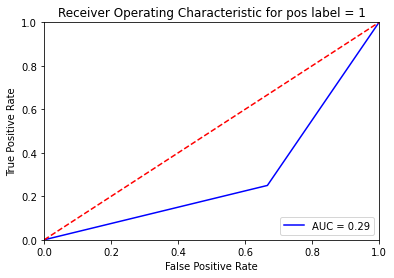

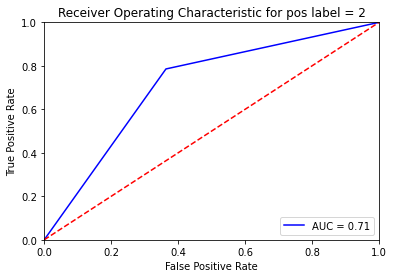

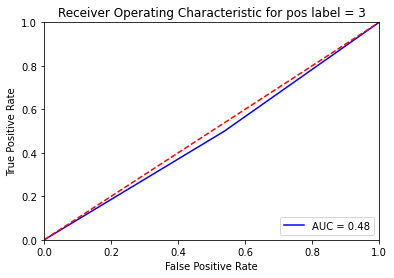

In [4]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# fit model
gnb_clf = GNB()
gnb_clf.fit(X, y)

# predict the label
preds = gnb_clf.predict(X_test)

for class_value in pd.unique(y):
    # calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, threshold = roc_curve(y_test, preds, pos_label=class_value)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.title('Receiver Operating Characteristic for pos label = %d' % class_value)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()